In [54]:
import scanpy as sc
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


import random

In [55]:
with open("data_augmentation_GSE174188.csv", 'r') as file:
    df = pd.read_csv(file, index_col = 0)

age = df["age"].astype(int)
#df = df.drop(columns = ["mean_DC","std_NK", "std_CD4T", "std_CD8T", "std_B", "std_Monocyte", "std_DC"], axis = 1 )
df = df.drop(columns = "age", axis = 1)

In [56]:
df

,mean_NK,mean_CD4T,mean_CD8T,mean_B,mean_Monocyte,mean_DC,std_NK,std_CD4T,std_CD8T,std_B,std_Monocyte,std_DC
HC-519_1,4.250463,2.101322,2.585653,2.275958,4.256917,0.995282,0.219740,0.153563,0.140392,0.173827,0.270898,0.039002
HC-519_2,4.233671,2.125010,2.608677,2.249835,4.300351,0.978386,0.199198,0.149960,0.197166,0.096902,0.258499,0.085476
HC-519_3,4.266166,2.135315,2.601588,2.236187,4.253217,0.953375,0.223695,0.177710,0.155687,0.186116,0.216263,0.043319
HC-519_4,4.273546,2.080197,2.601157,2.238966,4.264690,0.994676,0.217150,0.174626,0.163971,0.186315,0.261485,0.086960
HC-519_5,4.324083,2.141739,2.615713,2.262450,4.253062,0.957692,0.228844,0.132216,0.144391,0.153588,0.193030,0.050106
...,...,...,...,...,...,...,...,...,...,...,...,...
IGTB1731_IGTB1731_6,6.563656,3.568826,4.199865,3.961308,5.613795,1.637987,0.244200,0.189973,0.159651,0.136891,0.203070,0.122695
IGTB1731_IGTB1731_7,6.596188,3.580332,4.289095,3.913684,5.553950,1.640019,0.258587,0.130674,0.185953,0.124926,0.246717,0.078834
IGTB1731_IGTB1731_8,6.592616,3.584274,4.251048,3.960035,5.568194,1.599903,0.241156,0.173601,0.174416,0.155811,0.245737,0.078717
IGTB1731_IGTB1731_9,6.570584,3.537206,4.293931,3.941113,5.570133,1.641331,0.227840,0.175775,0.160713,0.160330,0.211768,0.060764


In [57]:
def train_test_split(df, age, random_size):
    #X_train, X_test, y_train, y_test = train_test_split(df, age, test_size=test_size, random_state=42)
    # 生成10個0到92之間的隨機整數
    random_numbers = random.sample(range(93), random_size)
    X_test = pd.DataFrame()
    y_test = pd.Series(dtype='int')
    for i in random_numbers:
        X_test = pd.concat([X_test, df.iloc[i*10:i*10+10]])
        y_test = pd.concat([y_test, age.iloc[i*10:i*10+10]])
        df.drop(df.index[i*10: i*10+10])
        age.drop(age.index[i*10: i*10+10])
    X_train = df
    y_train = age
    return X_train, X_test, y_train, y_test

def XGBR(X_train, X_test, y_train, y_test, n_estimators=65, max_depth=4, colsample_bytree = 1, gamma = 0.1, min_child_weight = 1, subsample = 0.8):
    # n_jobs=-1處理器全開
    xgbrModel = xgb.XGBRegressor(n_estimators = n_estimators, n_jobs=-1, max_depth = max_depth,
                                 colsample_bytree = colsample_bytree, gamma = gamma, min_child_weight = min_child_weight,
                                subsample = subsample, eval_metric="rmse")  
    # 創建k折交叉驗證對象
    kf = KFold(n_splits=10, shuffle=True)

    # 進行 k-fold cross-validation，例如 k=10
    scores = cross_val_score(xgbrModel, X_train, y_train, cv=kf)
    print('Cross-validation scores: ', scores)

    # train model with early stopping
    eval_set = [(X_test, y_test)]
    xgbrModel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = xgbrModel.predict(X_test)

    # 計算均方誤差（Mean Squared Error, MSE）
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')

    # 計算平均絕對誤差（Mean Absolute Error, MAE）
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')

    # 預測成功的比例
    print('Train Set score: ',xgbrModel.score(X_train,y_train))
    print('Test Set score: ',xgbrModel.score(X_test,y_test))
    # 計算皮爾森相關係數
    corr, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation: {corr}')
    plt.scatter(y_test, y_pred, s=10, label='True')
    plt.xlabel('Actual Ages')
    plt.ylabel('Predicted Ages')
    plt.title('Actual vs Predicted Ages')
    plt.show()


    print('特徵重要程度: ',xgbrModel.feature_importances_)
    
def RandomForestRegression(X_train, X_test, y_train, y_test, n_estimators=10):
    # n_jobs=-1處理器全開
    RFR = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1)# , random_state=0
    # 創建k折交叉驗證對象
    kf = KFold(n_splits=10, shuffle=True)
    # 進行 k-fold cross-validation，例如 k=10
    scores = cross_val_score(RFR, X_train, y_train, cv=kf)
    print('Cross-validation scores: ', scores)

    # train model
    RFR.fit(X_train, y_train)

    y_pred = RFR.predict(X_test)

    # 計算均方誤差（Mean Squared Error, MSE）
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')

    # 計算平均絕對誤差（Mean Absolute Error, MAE）
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')

    # 預測成功的比例
    print('Train Set score: ',RFR.score(X_train,y_train))
    print('Test Set score: ',RFR.score(X_test,y_test))

    # 計算皮爾森相關係數
    corr, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation: {corr}')

    plt.scatter(y_test, y_pred, s=10, label='True')
    plt.xlabel('Actual Ages')
    plt.ylabel('Predicted Ages')
    plt.title('Actual vs Predicted Ages')
    plt.show()
    
    
    print('特徵重要程度: ',RFR.feature_importances_)
    #print('樹的深度: ',RFR.get_depth)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(df, age, 30)

Cross-validation scores:  [0.76289937 0.70939932 0.79164755 0.80538081 0.81673289 0.7694772
 0.75916867 0.71822791 0.82629831 0.63393277]
Mean Squared Error (MSE): 34.061693075211636
Mean Absolute Error (MAE): 4.349420102437337
Train Set score:  0.8501466662093529
Test Set score:  0.7993761574355503
Pearson correlation: 0.9045474633727804


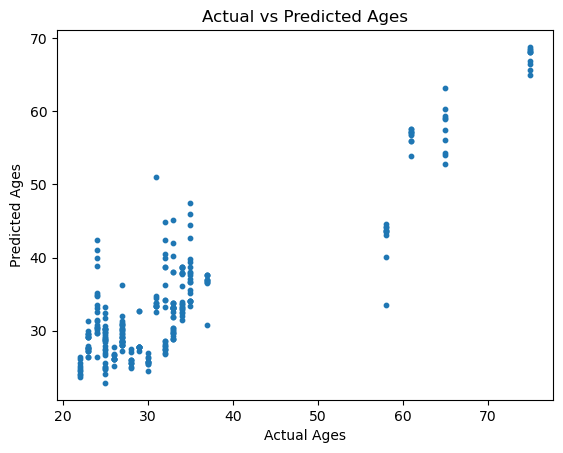

特徵重要程度:  [0.09056703 0.1326077  0.18510775 0.21787764 0.11124714 0.14690028
 0.         0.02327307 0.02073984 0.01145743 0.03271106 0.02751094]


In [107]:
XGBR(X_train, X_test, y_train, y_test, n_estimators=45, max_depth=2, colsample_bytree = 1, gamma = 0.1, min_child_weight = 1, subsample = 0.8)

Cross-validation scores:  [0.84204618 0.94094123 0.96871123 0.93200775 0.87659085 0.9831444
 0.93874253 0.84975632 0.93755678 0.94165697]
Mean Squared Error (MSE): 2.742633333333333
Mean Absolute Error (MAE): 0.41100000000000003
Train Set score:  0.9858578047408205
Test Set score:  0.9838458517941636
Pearson correlation: 0.9921370950219754


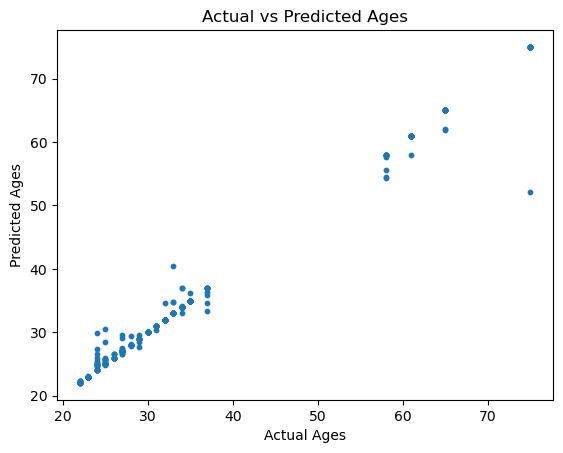

特徵重要程度:  [0.15913967 0.16677117 0.19054741 0.273638   0.07917385 0.10512558
 0.0009096  0.00996825 0.00251569 0.00307128 0.00774308 0.00139642]


In [108]:
RandomForestRegression(X_train, X_test, y_train, y_test, n_estimators=10)

# SLE 

In [94]:
with open("data_augmentation_GSE174188_SLE.csv", 'r') as file:
    df_SLE = pd.read_csv(file, index_col = 0)

age_SLE = df_SLE["age"].astype(int)
#df = df.drop(columns = ["mean_DC","std_NK", "std_CD4T", "std_CD8T", "std_B", "std_Monocyte", "std_DC"], axis = 1 )
df_SLE = df_SLE.drop(columns = "age", axis = 1)

Cross-validation scores:  [0.89522388 0.89350907 0.89217481 0.92854646 0.86047096 0.94544251
 0.93238391 0.94050308 0.90272827 0.92173268]
Mean Squared Error (MSE): 1.3717147816159074
Mean Absolute Error (MAE): 0.8378759765625
Train Set score:  0.9909431234408937
Test Set score:  0.9889347103276509
Pearson correlation: 0.9947160116629871


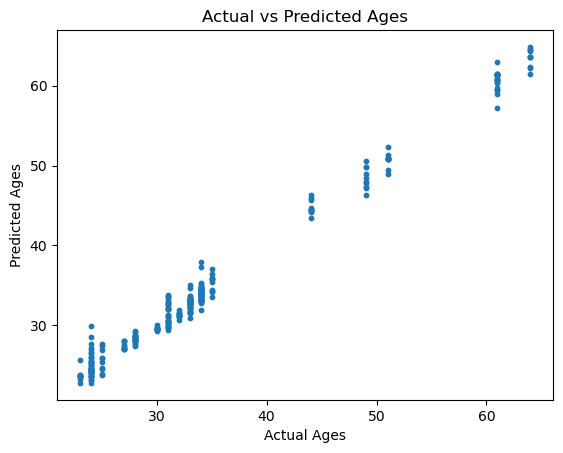

特徵重要程度:  [0.14566852 0.17117806 0.16016327 0.26875195 0.08497985 0.12577462
 0.00672425 0.00850266 0.01144748 0.00584799 0.00665445 0.004307  ]


In [100]:
# n_jobs=-1處理器全開
xgbrModel = xgb.XGBRegressor(n_estimators = 45, n_jobs=-1, max_depth = 4,
                            colsample_bytree = 1, gamma = 0.1, min_child_weight = 1,
                            subsample = 0.8, eval_metric="rmse")  
# 創建k折交叉驗證對象
kf = KFold(n_splits=10, shuffle=True)

# 進行 k-fold cross-validation，例如 k=10
scores = cross_val_score(xgbrModel, X_train, y_train, cv=kf)
print('Cross-validation scores: ', scores)

# train model with early stopping
eval_set = [(X_test, y_test)]
xgbrModel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

y_pred = xgbrModel.predict(X_test)

# 計算均方誤差（Mean Squared Error, MSE）
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# 計算平均絕對誤差（Mean Absolute Error, MAE）
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# 預測成功的比例
print('Train Set score: ',xgbrModel.score(X_train,y_train))
print('Test Set score: ',xgbrModel.score(X_test,y_test))
# 計算皮爾森相關係數
corr, _ = pearsonr(y_test, y_pred)
print(f'Pearson correlation: {corr}')
plt.scatter(y_test, y_pred, s=10, label='True')
plt.xlabel('Actual Ages')
plt.ylabel('Predicted Ages')
plt.title('Actual vs Predicted Ages')
plt.show()


print('特徵重要程度: ',xgbrModel.feature_importances_)

In [101]:
SLE_pred = xgbrModel.predict(df_SLE)

# 計算均方誤差（Mean Squared Error, MSE）
mse_SLE = mean_squared_error(age_SLE, SLE_pred)
print(f'Mean Squared Error (MSE): {mse_SLE}')

# 計算平均絕對誤差（Mean Absolute Error, MAE）
mae_SLE = mean_absolute_error(age_SLE, SLE_pred)
print(f'Mean Absolute Error (MAE): {mae_SLE}')

Mean Squared Error (MSE): 437.0051745953772
Mean Absolute Error (MAE): 17.000086622340707


In [104]:
for i in range(len(age_SLE)):
    print(f"Actual: {age_SLE[i]} \tPredict: {SLE_pred[i]}")

Actual: 20 	Predict: 72.54037475585938
Actual: 20 	Predict: 71.90628051757812
Actual: 20 	Predict: 73.70484161376953
Actual: 20 	Predict: 71.03535461425781
Actual: 20 	Predict: 74.0577392578125
Actual: 20 	Predict: 72.06732177734375
Actual: 20 	Predict: 72.69793701171875
Actual: 20 	Predict: 72.8910903930664
Actual: 20 	Predict: 72.42078399658203
Actual: 20 	Predict: 71.00271606445312
Actual: 21 	Predict: 52.521575927734375
Actual: 21 	Predict: 51.53883361816406
Actual: 21 	Predict: 51.88431167602539
Actual: 21 	Predict: 51.345603942871094
Actual: 21 	Predict: 50.87975311279297
Actual: 21 	Predict: 53.781394958496094
Actual: 21 	Predict: 55.56550979614258
Actual: 21 	Predict: 53.486637115478516
Actual: 21 	Predict: 51.18819808959961
Actual: 21 	Predict: 50.67356872558594
Actual: 21 	Predict: 35.69169998168945
Actual: 21 	Predict: 32.82853317260742
Actual: 21 	Predict: 32.65463638305664
Actual: 21 	Predict: 33.559844970703125
Actual: 21 	Predict: 34.33446502685547
Actual: 21 	Predict: 3

Pearson correlation: 0.12178126117713653


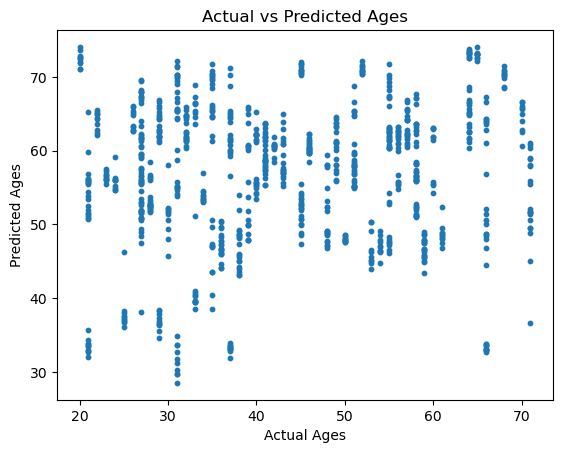

In [105]:
# 計算皮爾森相關係數
corr_SLE, _ = pearsonr(age_SLE, SLE_pred)
print(f'Pearson correlation: {corr_SLE}')
plt.scatter(age_SLE, SLE_pred, s=10, label='True')
plt.xlabel('Actual Ages')
plt.ylabel('Predicted Ages')
plt.title('Actual vs Predicted Ages')
plt.show()